In [1]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import SwinModel
from transformers.models.swin.modeling_swin import SwinLayer

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

import torch
import torch.nn as nn
from transformers.models.swin.modeling_swin import SwinPatchEmbeddings, SwinPatchMerging, SwinLayer
from transformers import SwinConfig
from typing import Tuple, Optional
# --- Cài đặt tham số cố định ---
IMG_SIZE = 320 
NUM_EPOCHS = 200
LEARNING_RATE = 1e-4
SEED = 42
BATCH_SIZE = 2
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Đường dẫn dữ liệu (Thay đổi nếu cần) ---
train_img_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\train\image'
train_mask_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\train\label'
val_img_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\val\image'
val_mask_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\val\label'

# --- Thu thập đường dẫn tệp ảnh và mask ---
train_img_paths = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir)])
train_mask_paths = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir)])
val_img_paths = sorted([os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)])
val_mask_paths = sorted([os.path.join(val_mask_dir, f) for f in os.listdir(val_mask_dir)])


c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Using device: cuda


In [2]:
class CrackDetectionDataset(Dataset):
    def __init__(self, image_filenames, mask_filenames, transform=None):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_filenames[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.mask_filenames[idx], cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask > 0, 255.0, 0.0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        
        mask = mask / 255.0
        mask = mask.unsqueeze(0)

        return img, mask

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [3]:
class PatchExpanding(nn.Module):
    def __init__(self, input_resolution: Tuple[int, int], dim: int, return_vector: bool = True):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.expand = nn.Linear(dim, 2 * dim, bias=False)
        self.norm = nn.LayerNorm(dim // 2)
        self.return_vector = return_vector

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        H, W = self.input_resolution
        x = x.view(-1, H, W, self.dim)
        x = self.expand(x)
        B, H, W, C = x.shape
        x = x.view(B, H, W, 2, 2, C // 4)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H * 2, W * 2, C // 4)
        x = self.norm(x)
        if self.return_vector:
            x = x.view(B, -1, C // 4)
        return x


class FinalPatchExpanding(nn.Module):
    def __init__(self, dim: int, scale_factor: int = 4):
        super().__init__()
        self.scale_factor = scale_factor
        self.output_dim = dim // scale_factor

        expand_dim = self.output_dim * (scale_factor**2)
        self.expand = nn.Linear(dim, expand_dim, bias=False)

        self.norm = nn.LayerNorm(self.output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L, _ = x.shape
        H = W = int(np.sqrt(L))
        x_expanded = self.expand(x)

        x_reshaped = x_expanded.view(B, H, W, self.scale_factor, self.scale_factor, self.output_dim)

        x_permuted = x_reshaped.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H * self.scale_factor, W * self.scale_factor, self.output_dim)

        x_normed = self.norm(x_permuted)

        output = x_normed.view(B, -1, self.output_dim)
        
        return output


class SkipAttention(nn.Module):
    def __init__(self, query_dim: int, context_dim: Optional[int] = None, num_heads: int = 8, dim_head: int = 64):
        super().__init__()
        if context_dim is None:
            context_dim = query_dim
        
        self.attn = nn.MultiheadAttention(embed_dim=query_dim, num_heads=num_heads, 
                                          kdim=context_dim, vdim=context_dim, 
                                          batch_first=True)
        self.norm = nn.LayerNorm(query_dim)

    def forward(self, query: torch.Tensor, context: torch.Tensor) -> torch.Tensor:
        attn_output, _ = self.attn(query=query, key=context, value=context)
        return self.norm(query + attn_output)


class ResidualSwinBlock(nn.Module):
    def __init__(self, config: SwinConfig, dim: int, input_resolution: Tuple[int, int], num_layers: int, num_heads: int):
        super().__init__()
        self.layers = nn.ModuleList([
            SwinLayer(
                config=config, 
                dim=dim, 
                input_resolution=input_resolution, 
                num_heads=num_heads, 
                shift_size=0 if (i % 2 == 0) else config.window_size // 2
            ) for i in range(num_layers)
        ])
        
    def forward(self, x: torch.Tensor, input_resolution: Tuple[int, int]) -> torch.Tensor:
        residual = x
        for layer in self.layers:
            x = layer(x, input_resolution)[0]
        return x + residual


class iSwinUnet(nn.Module):
    def __init__(self, num_classes: int = 1, img_size: int = 320, pretrained: bool = True):
        super().__init__()
        self.num_classes = num_classes
        self.img_size = img_size
        
        # --- Config ---
        config = SwinConfig(image_size=img_size, patch_size=4, window_size=7)
        self.config = config
        self.encoder_channels = [config.embed_dim * (2**i) for i in range(len(config.depths))]

        # --- Encoder ---
        self.patch_embed = SwinPatchEmbeddings(config)
        self.pos_drop = nn.Dropout(p=config.hidden_dropout_prob)

        self.encoder_stage1 = ResidualSwinBlock(config, self.encoder_channels[0], (img_size//4, img_size//4), config.depths[0], config.num_heads[0])
        self.merge1 = SwinPatchMerging(input_resolution=(img_size//4, img_size//4), dim=self.encoder_channels[0])
        
        self.encoder_stage2 = ResidualSwinBlock(config, self.encoder_channels[1], (img_size//8, img_size//8), config.depths[1], config.num_heads[1])
        self.merge2 = SwinPatchMerging(input_resolution=(img_size//8, img_size//8), dim=self.encoder_channels[1])

        self.encoder_stage3 = ResidualSwinBlock(config, self.encoder_channels[2], (img_size//16, img_size//16), config.depths[2], config.num_heads[2])
        self.merge3 = SwinPatchMerging(input_resolution=(img_size//16, img_size//16), dim=self.encoder_channels[2])
        
        self.bottleneck = ResidualSwinBlock(config, self.encoder_channels[3], (img_size//32, img_size//32), config.depths[3], config.num_heads[3])

        self.decoder_expand3 = PatchExpanding(input_resolution=(img_size//32, img_size//32), dim=self.encoder_channels[3])
        self.skip_attn3 = SkipAttention(query_dim=self.encoder_channels[2], context_dim=self.encoder_channels[2], num_heads=config.num_heads[2])
        self.decoder_stage3 = ResidualSwinBlock(config, self.encoder_channels[2], (img_size//16, img_size//16), config.depths[2], config.num_heads[2])

        self.decoder_expand2 = PatchExpanding(input_resolution=(img_size//16, img_size//16), dim=self.encoder_channels[2])
        self.skip_attn2 = SkipAttention(query_dim=self.encoder_channels[1], context_dim=self.encoder_channels[1], num_heads=config.num_heads[1])
        self.decoder_stage2 = ResidualSwinBlock(config, self.encoder_channels[1], (img_size//8, img_size//8), config.depths[1], config.num_heads[1])

        self.decoder_expand1 = PatchExpanding(input_resolution=(img_size//8, img_size//8), dim=self.encoder_channels[1])
        self.skip_attn1 = SkipAttention(query_dim=self.encoder_channels[0], context_dim=self.encoder_channels[0], num_heads=config.num_heads[0])
        self.decoder_stage1 = ResidualSwinBlock(config, self.encoder_channels[0], (img_size//4, img_size//4), config.depths[0], config.num_heads[0])

        self.final_expand = FinalPatchExpanding(dim=self.encoder_channels[0], scale_factor=4)
        self.final_conv = nn.Conv2d(self.final_expand.output_dim, num_classes, kernel_size=1)

        if pretrained:
            self.load_pretrained_weights()

    def load_pretrained_weights(self):
            print("Loading pretrained weights for Swin-Tiny encoder...")
            try:
                swin_original = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
                original_state_dict = swin_original.state_dict()

                model_state_dict = self.state_dict()

                prefix_mapping = {
                    'embeddings.patch_embeddings': 'patch_embed',
                    'encoder.layers.0.downsample': 'merge1',
                    'encoder.layers.1.downsample': 'merge2',
                    'encoder.layers.2.downsample': 'merge3',
                }

                stage_mapping = {
                    'encoder.layers.0': 'encoder_stage1',
                    'encoder.layers.1': 'encoder_stage2',
                    'encoder.layers.2': 'encoder_stage3',
                    'encoder.layers.3': 'bottleneck',
                }

                loaded_count = 0
                
                orig_pos_embed_key = 'embeddings.absolute_position_embedding'
                if orig_pos_embed_key in original_state_dict:
                    orig_pos_embed = original_state_dict[orig_pos_embed_key]
                    target_pos_embed = model_state_dict[orig_pos_embed_key]
                    if orig_pos_embed.shape != target_pos_embed.shape:
                        print(f"Interpolating absolute position embedding due to size mismatch...")
                        orig_pos_embed_spatial = orig_pos_embed[0, 1:, :].permute(1, 0)

                        H_orig = W_orig = int((orig_pos_embed.shape[1] - 1) ** 0.5)
                        orig_pos_embed_spatial = orig_pos_embed_spatial.view(1, -1, H_orig, W_orig)
                        H_target = W_target = int((target_pos_embed.shape[1] - 1) ** 0.5)
                        interp_pos_embed = nn.functional.interpolate(
                            orig_pos_embed_spatial, size=(H_target, W_target), mode='bicubic', align_corners=False
                        )
                        interp_pos_embed = interp_pos_embed.view(1, -1, H_target * W_target).permute(0, 2, 1)
                        # Thêm lại token [CLS]
                        final_pos_embed = torch.cat((orig_pos_embed[0, 0:1, :], interp_pos_embed[0]), dim=0).unsqueeze(0)
                        model_state_dict[orig_pos_embed_key] = final_pos_embed
                        loaded_count += 1
                    del original_state_dict[orig_pos_embed_key]

                for key_orig, value in original_state_dict.items():
                    new_key = None

                    if 'pooler' in key_orig:
                        continue

                    for old_prefix, new_prefix in prefix_mapping.items():
                        if key_orig.startswith(old_prefix):
                            new_key = key_orig.replace(old_prefix, new_prefix)
                            break

                    if new_key is None:
                        for old_stage_prefix, new_stage_prefix in stage_mapping.items():
                            if key_orig.startswith(old_stage_prefix):
                                remainder = key_orig[len(old_stage_prefix):]
                                if remainder.startswith('.blocks'):
                                    remainder = remainder.replace('.blocks', '', 1)
                                    new_key = f"{new_stage_prefix}.layers{remainder}"
                                break

                    if new_key is None:
                        if key_orig.startswith('embeddings.norm'):
                            new_key = key_orig.replace('embeddings.norm', 'patch_embed.norm')
                        elif key_orig.startswith('encoder.norm'):
                            continue

                    if new_key and new_key in model_state_dict and model_state_dict[new_key].shape == value.shape:
                        model_state_dict[new_key] = value
                        loaded_count += 1
                    else:
                        pass

                self.load_state_dict(model_state_dict, strict=False)

                expected_keys = len([k for k in swin_original.state_dict().keys() if 'pooler' not in k and 'encoder.norm' not in k])
                print(f"✅ Successfully loaded {loaded_count}/{expected_keys} tensors from pretrained Swin-Tiny.")
                print("   (Any unloaded tensors are expected to be from the decoder and final layers).")

            except Exception as e:
                print(f"❌ ERROR: Could not load pretrained weights. Error: {e}. Training from scratch.")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        s1_skip = self.patch_embed(x)[0]
        s1_skip = self.pos_drop(s1_skip)
        
        s1_out = self.encoder_stage1(s1_skip, (self.img_size//4, self.img_size//4))
        s2_in = self.merge1(s1_out, (self.img_size//4, self.img_size//4))
        
        s2_out = self.encoder_stage2(s2_in, (self.img_size//8, self.img_size//8))
        s3_in = self.merge2(s2_out, (self.img_size//8, self.img_size//8))

        s3_out = self.encoder_stage3(s3_in, (self.img_size//16, self.img_size//16))
        b_in = self.merge3(s3_out, (self.img_size//16, self.img_size//16))
        
        b_out = self.bottleneck(b_in, (self.img_size//32, self.img_size//32))
 
        d3_in = self.decoder_expand3(b_out)
        d3_in = self.skip_attn3(query=d3_in, context=s3_out)
        d3_out = self.decoder_stage3(d3_in, (self.img_size//16, self.img_size//16))
 
        d2_in = self.decoder_expand2(d3_out)
        d2_in = self.skip_attn2(query=d2_in, context=s2_out)
        d2_out = self.decoder_stage2(d2_in, (self.img_size//8, self.img_size//8))

        d1_in = self.decoder_expand1(d2_out)
        d1_in = self.skip_attn1(query=d1_in, context=s1_out)
        d1_out = self.decoder_stage1(d1_in, (self.img_size//4, self.img_size//4))
        
        final_features = self.final_expand(d1_out)
        
        B, L, C = final_features.shape
        H = W = int(np.sqrt(L))
        final_features = final_features.permute(0, 2, 1).contiguous().view(B, C, H, W)
        
        output = self.final_conv(final_features)
        
        return output

In [4]:

class IoULoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(IoULoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection
        
        iou = (intersection + self.smooth) / (union + self.smooth)

        return 1 - iou

class CombinedLoss(nn.Module):
    def __init__(self, pos_weight_value, bce_weight=1.0, iou_weight=1.0):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.iou_weight = iou_weight
        # pos_weight cần phải là một tensor
        self.pos_weight = torch.tensor([pos_weight_value])
        # Khởi tạo BCE loss với pos_weight
        self.bce_loss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        self.iou_loss = IoULoss()
        print(f"CombinedLoss initialized with BCE weight: {bce_weight}, IoU weight: {iou_weight}")

    def forward(self, inputs, targets):
        self.bce_loss.pos_weight = self.bce_loss.pos_weight.to(inputs.device)
        
        loss_bce = self.bce_loss(inputs, targets)
        loss_iou = self.iou_loss(inputs, targets)

        combined_loss = self.bce_weight * loss_bce + self.iou_weight * loss_iou
        
        return combined_loss


def calculate_metrics(predicted_masks, true_masks, smooth=1e-6):
    predicted_masks = predicted_masks.view(-1)
    true_masks = true_masks.view(-1)
    
    intersection = (predicted_masks * true_masks).sum()
    union = (predicted_masks + true_masks).sum() - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    dice = (2. * intersection + smooth) / (predicted_masks.sum() + true_masks.sum() + smooth)
    
    return iou.item(), dice.item()



In [5]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, callbacks_config, start_epoch=0, best_val_iou=0.0, history=None):
    best_iou = best_val_iou
    patience_counter = 0
    checkpoint_path = callbacks_config.get('checkpoint_path', 'model_best.pth')
    
    if history is None:
        history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': [], 'lr': []}

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss, train_iou = 0.0, 0.0
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, masks in loop:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted_masks = (torch.sigmoid(outputs) > 0.5).float()
            
            batch_iou, _ = calculate_metrics(predicted_masks, masks)
            train_iou += batch_iou
            
            loop.set_postfix(loss=loss.item(), iou=batch_iou)

        history['train_loss'].append(train_loss / len(train_loader))
        history['train_iou'].append(train_iou / len(train_loader))
        
        model.eval()
        val_loss, val_iou = 0.0, 0.0
        
        loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for images, masks in loop:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item()
                predicted_masks = (torch.sigmoid(outputs) > 0.5).float()
                
                batch_iou, _ = calculate_metrics(predicted_masks, masks)
                val_iou += batch_iou

        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        
        history['val_loss'].append(avg_val_loss)
        history['val_iou'].append(avg_val_iou)
        
        scheduler.step(avg_val_loss) # Sử dụng validation loss cho scheduler
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        
        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train -> Loss: {history['train_loss'][-1]:.4f}, IoU: {history['train_iou'][-1]:.4f}")
        print(f"  Val   -> Loss: {avg_val_loss:.4f}, IoU: {avg_val_iou:.4f}")
        print(f"  LR: {current_lr:.8f}")

        if avg_val_iou > best_iou:
            best_iou = avg_val_iou
            patience_counter = 0
            print(f"🚀 New best validation IoU: {best_iou:.4f}. Saving model...")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_iou': best_iou,
                'scheduler_state_dict': scheduler.state_dict(),
                'history': history
            }, checkpoint_path)
        else:
            patience_counter += 1
            print(f"Validation IoU did not improve. Patience: {patience_counter}/{callbacks_config['patience']}")
            if patience_counter >= callbacks_config['patience']:
                print("Early stopping!")
                break
    return history

# --- Hàm vẽ biểu đồ (Đã chỉnh sửa chỉ dùng IoU) ---
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Sửa đổi: Tạo một hàng 3 cột cho 3 biểu đồ
    fig, axs = plt.subplots(1, 3, figsize=(22, 6))

    # Biểu đồ 1: Loss
    axs[0].plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    axs[0].plot(epochs, history['val_loss'], 'o-', label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set(xlabel='Epoch', ylabel='Loss')
    axs[0].legend()

    # Biểu đồ 2: IoU
    axs[1].plot(epochs, history['train_iou'], 'o-', label='Train IoU')
    axs[1].plot(epochs, history['val_iou'], 'o-', label='Validation IoU')
    axs[1].set_title('Training and Validation IoU')
    axs[1].set(xlabel='Epoch', ylabel='IoU')
    axs[1].legend()

    axs[2].plot(epochs, history['lr'], 'o-', label='Learning Rate', color='purple')
    axs[2].set_title('Learning Rate per Epoch')
    axs[2].set(xlabel='Epoch', ylabel='Learning Rate')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

def evaluate_model(model, data_loader, threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc="Evaluating"):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(images)
            preds = torch.sigmoid(outputs)

            preds = (preds > threshold).float()

            all_preds.append(preds.view(-1).cpu().numpy())
            all_targets.append(masks.view(-1).cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    iou = jaccard_score(all_targets, all_preds, zero_division=0)

    print(f"\n--- Evaluation Metrics ---")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"IoU:       {iou:.4f}")


Initializing iSwinUnet model (paper version)...
Loading pretrained weights for Swin-Tiny encoder...
✅ Successfully loaded 227/231 tensors from pretrained Swin-Tiny.
   (Any unloaded tensors are expected to be from the decoder and final layers).
CombinedLoss initialized with BCE weight: 1.0, IoU weight: 1.0
!!! USING BCEWithLogitsLoss with pos_weight=22 !!!
Model has 41,657,773 trainable parameters.
✅ Found initial weights at: iswin_unet_paper_IOU.pth
   Loading model weights for fine-tuning. Optimizer and scheduler are reset.


C:\Users\Admin\AppData\Local\Temp\ipykernel_13548\316635104.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(INITIAL_WEIGHTS_PATH, map_location=D

   Starting new training run from Epoch 0.

--- Starting Training ---


Epoch 1/200 [Val]: 100%|██████████| 200/200 [00:21<00:00,  9.44it/s]


Epoch 1 Summary:
  Train -> Loss: 0.5984, IoU: 0.6165
  Val   -> Loss: 0.9554, IoU: 0.5022
  LR: 0.00010000
🚀 New best validation IoU: 0.5022. Saving model...


Epoch 2/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.41it/s]


Epoch 2 Summary:
  Train -> Loss: 0.5462, IoU: 0.6233
  Val   -> Loss: 0.9469, IoU: 0.4999
  LR: 0.00010000
Validation IoU did not improve. Patience: 1/20


Epoch 3/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.79it/s]


Epoch 3 Summary:
  Train -> Loss: 0.5369, IoU: 0.6270
  Val   -> Loss: 0.9244, IoU: 0.4940
  LR: 0.00010000
Validation IoU did not improve. Patience: 2/20


Epoch 4/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.27it/s]


Epoch 4 Summary:
  Train -> Loss: 0.5343, IoU: 0.6235
  Val   -> Loss: 1.0094, IoU: 0.5035
  LR: 0.00010000
🚀 New best validation IoU: 0.5035. Saving model...


Epoch 5/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.01it/s]


Epoch 5 Summary:
  Train -> Loss: 0.5314, IoU: 0.6257
  Val   -> Loss: 0.9686, IoU: 0.5010
  LR: 0.00010000
Validation IoU did not improve. Patience: 1/20


Epoch 6/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.82it/s]


Epoch 6 Summary:
  Train -> Loss: 0.5442, IoU: 0.6187
  Val   -> Loss: 0.9593, IoU: 0.4962
  LR: 0.00010000
Validation IoU did not improve. Patience: 2/20


Epoch 7/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.73it/s]


Epoch 7 Summary:
  Train -> Loss: 0.5344, IoU: 0.6211
  Val   -> Loss: 0.9766, IoU: 0.5040
  LR: 0.00010000
🚀 New best validation IoU: 0.5040. Saving model...


Epoch 8/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.03it/s]


Epoch 8 Summary:
  Train -> Loss: 0.5235, IoU: 0.6277
  Val   -> Loss: 0.9723, IoU: 0.4982
  LR: 0.00010000
Validation IoU did not improve. Patience: 1/20


Epoch 9/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.03it/s]


Epoch 9 Summary:
  Train -> Loss: 0.5186, IoU: 0.6310
  Val   -> Loss: 0.9955, IoU: 0.5032
  LR: 0.00005000
Validation IoU did not improve. Patience: 2/20


Epoch 10/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.89it/s]


Epoch 10 Summary:
  Train -> Loss: 0.4968, IoU: 0.6443
  Val   -> Loss: 1.0111, IoU: 0.5103
  LR: 0.00005000
🚀 New best validation IoU: 0.5103. Saving model...


Epoch 11/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.42it/s]


Epoch 11 Summary:
  Train -> Loss: 0.4867, IoU: 0.6519
  Val   -> Loss: 0.9713, IoU: 0.5084
  LR: 0.00005000
Validation IoU did not improve. Patience: 1/20


Epoch 12/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.73it/s]


Epoch 12 Summary:
  Train -> Loss: 0.4850, IoU: 0.6526
  Val   -> Loss: 0.9929, IoU: 0.5110
  LR: 0.00005000
🚀 New best validation IoU: 0.5110. Saving model...


Epoch 13/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.19it/s]


Epoch 13 Summary:
  Train -> Loss: 0.4798, IoU: 0.6538
  Val   -> Loss: 1.0042, IoU: 0.5149
  LR: 0.00005000
🚀 New best validation IoU: 0.5149. Saving model...


Epoch 14/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.96it/s]


Epoch 14 Summary:
  Train -> Loss: 0.4713, IoU: 0.6622
  Val   -> Loss: 1.0655, IoU: 0.5160
  LR: 0.00005000
🚀 New best validation IoU: 0.5160. Saving model...


Epoch 15/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.19it/s]


Epoch 15 Summary:
  Train -> Loss: 0.4670, IoU: 0.6642
  Val   -> Loss: 1.0434, IoU: 0.5148
  LR: 0.00002500
Validation IoU did not improve. Patience: 1/20


Epoch 16/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.98it/s]


Epoch 16 Summary:
  Train -> Loss: 0.4567, IoU: 0.6709
  Val   -> Loss: 1.0484, IoU: 0.5151
  LR: 0.00002500
Validation IoU did not improve. Patience: 2/20


Epoch 17/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.60it/s]


Epoch 17 Summary:
  Train -> Loss: 0.4496, IoU: 0.6759
  Val   -> Loss: 1.0429, IoU: 0.5141
  LR: 0.00002500
Validation IoU did not improve. Patience: 3/20


Epoch 18/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.52it/s]


Epoch 18 Summary:
  Train -> Loss: 0.4416, IoU: 0.6829
  Val   -> Loss: 1.0416, IoU: 0.5150
  LR: 0.00002500
Validation IoU did not improve. Patience: 4/20


Epoch 19/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.24it/s]


Epoch 19 Summary:
  Train -> Loss: 0.4450, IoU: 0.6778
  Val   -> Loss: 1.0692, IoU: 0.5165
  LR: 0.00002500
🚀 New best validation IoU: 0.5165. Saving model...


Epoch 20/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.12it/s]


Epoch 20 Summary:
  Train -> Loss: 0.4368, IoU: 0.6858
  Val   -> Loss: 1.0608, IoU: 0.5192
  LR: 0.00002500
🚀 New best validation IoU: 0.5192. Saving model...


Epoch 21/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.35it/s]


Epoch 21 Summary:
  Train -> Loss: 0.4412, IoU: 0.6807
  Val   -> Loss: 1.0180, IoU: 0.5116
  LR: 0.00001250
Validation IoU did not improve. Patience: 1/20


Epoch 22/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.06it/s]


Epoch 22 Summary:
  Train -> Loss: 0.4311, IoU: 0.6876
  Val   -> Loss: 1.0684, IoU: 0.5181
  LR: 0.00001250
Validation IoU did not improve. Patience: 2/20


Epoch 23/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.37it/s]


Epoch 23 Summary:
  Train -> Loss: 0.4338, IoU: 0.6860
  Val   -> Loss: 1.0567, IoU: 0.5167
  LR: 0.00001250
Validation IoU did not improve. Patience: 3/20


Epoch 24/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.72it/s]


Epoch 24 Summary:
  Train -> Loss: 0.4262, IoU: 0.6917
  Val   -> Loss: 1.0902, IoU: 0.5184
  LR: 0.00001250
Validation IoU did not improve. Patience: 4/20


Epoch 25/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.51it/s]


Epoch 25 Summary:
  Train -> Loss: 0.4207, IoU: 0.6947
  Val   -> Loss: 1.1048, IoU: 0.5170
  LR: 0.00001250
Validation IoU did not improve. Patience: 5/20


Epoch 26/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.01it/s]


Epoch 26 Summary:
  Train -> Loss: 0.4181, IoU: 0.6984
  Val   -> Loss: 1.1073, IoU: 0.5182
  LR: 0.00001250
Validation IoU did not improve. Patience: 6/20


Epoch 27/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.30it/s]


Epoch 27 Summary:
  Train -> Loss: 0.4189, IoU: 0.6950
  Val   -> Loss: 1.0676, IoU: 0.5144
  LR: 0.00000625
Validation IoU did not improve. Patience: 7/20


Epoch 28/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.86it/s]


Epoch 28 Summary:
  Train -> Loss: 0.4125, IoU: 0.7020
  Val   -> Loss: 1.0970, IoU: 0.5172
  LR: 0.00000625
Validation IoU did not improve. Patience: 8/20


Epoch 29/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.15it/s]


Epoch 29 Summary:
  Train -> Loss: 0.4180, IoU: 0.6972
  Val   -> Loss: 1.1094, IoU: 0.5193
  LR: 0.00000625
🚀 New best validation IoU: 0.5193. Saving model...


Epoch 30/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.26it/s]


Epoch 30 Summary:
  Train -> Loss: 0.4118, IoU: 0.7003
  Val   -> Loss: 1.1029, IoU: 0.5167
  LR: 0.00000625
Validation IoU did not improve. Patience: 1/20


Epoch 31/200 [Val]: 100%|██████████| 200/200 [00:17<00:00, 11.26it/s]


Epoch 31 Summary:
  Train -> Loss: 0.4107, IoU: 0.7022
  Val   -> Loss: 1.1195, IoU: 0.5180
  LR: 0.00000625
Validation IoU did not improve. Patience: 2/20


Epoch 32/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.01it/s]


Epoch 32 Summary:
  Train -> Loss: 0.4098, IoU: 0.7035
  Val   -> Loss: 1.1019, IoU: 0.5185
  LR: 0.00000625
Validation IoU did not improve. Patience: 3/20


Epoch 33/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.05it/s]


Epoch 33 Summary:
  Train -> Loss: 0.4103, IoU: 0.7025
  Val   -> Loss: 1.1289, IoU: 0.5187
  LR: 0.00000313
Validation IoU did not improve. Patience: 4/20


Epoch 34/200 [Val]: 100%|██████████| 200/200 [00:17<00:00, 11.59it/s]


Epoch 34 Summary:
  Train -> Loss: 0.4045, IoU: 0.7074
  Val   -> Loss: 1.1205, IoU: 0.5186
  LR: 0.00000313
Validation IoU did not improve. Patience: 5/20


Epoch 35/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.52it/s]


Epoch 35 Summary:
  Train -> Loss: 0.4081, IoU: 0.7028
  Val   -> Loss: 1.1296, IoU: 0.5182
  LR: 0.00000313
Validation IoU did not improve. Patience: 6/20


Epoch 36/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.29it/s]


Epoch 36 Summary:
  Train -> Loss: 0.4080, IoU: 0.7032
  Val   -> Loss: 1.1160, IoU: 0.5175
  LR: 0.00000313
Validation IoU did not improve. Patience: 7/20


Epoch 37/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.90it/s]


Epoch 37 Summary:
  Train -> Loss: 0.4067, IoU: 0.7048
  Val   -> Loss: 1.1139, IoU: 0.5179
  LR: 0.00000313
Validation IoU did not improve. Patience: 8/20


Epoch 38/200 [Val]: 100%|██████████| 200/200 [00:17<00:00, 11.50it/s]


Epoch 38 Summary:
  Train -> Loss: 0.4002, IoU: 0.7111
  Val   -> Loss: 1.1153, IoU: 0.5176
  LR: 0.00000313
Validation IoU did not improve. Patience: 9/20


Epoch 39/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.74it/s]


Epoch 39 Summary:
  Train -> Loss: 0.4034, IoU: 0.7068
  Val   -> Loss: 1.1144, IoU: 0.5182
  LR: 0.00000156
Validation IoU did not improve. Patience: 10/20


Epoch 40/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.43it/s]


Epoch 40 Summary:
  Train -> Loss: 0.4085, IoU: 0.7029
  Val   -> Loss: 1.1234, IoU: 0.5189
  LR: 0.00000156
Validation IoU did not improve. Patience: 11/20


Epoch 41/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.78it/s]


Epoch 41 Summary:
  Train -> Loss: 0.3994, IoU: 0.7108
  Val   -> Loss: 1.1261, IoU: 0.5184
  LR: 0.00000156
Validation IoU did not improve. Patience: 12/20


Epoch 42/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.62it/s]


Epoch 42 Summary:
  Train -> Loss: 0.3989, IoU: 0.7112
  Val   -> Loss: 1.1249, IoU: 0.5182
  LR: 0.00000156
Validation IoU did not improve. Patience: 13/20


Epoch 43/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.89it/s]


Epoch 43 Summary:
  Train -> Loss: 0.3960, IoU: 0.7135
  Val   -> Loss: 1.1336, IoU: 0.5186
  LR: 0.00000156
Validation IoU did not improve. Patience: 14/20


Epoch 44/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.44it/s]


Epoch 44 Summary:
  Train -> Loss: 0.4032, IoU: 0.7069
  Val   -> Loss: 1.1252, IoU: 0.5181
  LR: 0.00000156
Validation IoU did not improve. Patience: 15/20


Epoch 45/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.99it/s]


Epoch 45 Summary:
  Train -> Loss: 0.3983, IoU: 0.7107
  Val   -> Loss: 1.1315, IoU: 0.5186
  LR: 0.00000078
Validation IoU did not improve. Patience: 16/20


Epoch 46/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 13.01it/s]


Epoch 46 Summary:
  Train -> Loss: 0.4032, IoU: 0.7067
  Val   -> Loss: 1.1289, IoU: 0.5183
  LR: 0.00000078
Validation IoU did not improve. Patience: 17/20


Epoch 47/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.53it/s]


Epoch 47 Summary:
  Train -> Loss: 0.3984, IoU: 0.7096
  Val   -> Loss: 1.1338, IoU: 0.5182
  LR: 0.00000078
Validation IoU did not improve. Patience: 18/20


Epoch 48/200 [Val]: 100%|██████████| 200/200 [00:15<00:00, 12.96it/s]


Epoch 48 Summary:
  Train -> Loss: 0.3961, IoU: 0.7127
  Val   -> Loss: 1.1376, IoU: 0.5185
  LR: 0.00000078
Validation IoU did not improve. Patience: 19/20


Epoch 49/200 [Val]: 100%|██████████| 200/200 [00:16<00:00, 12.49it/s]


Epoch 49 Summary:
  Train -> Loss: 0.4070, IoU: 0.7038
  Val   -> Loss: 1.1311, IoU: 0.5185
  LR: 0.00000078
Validation IoU did not improve. Patience: 20/20
Early stopping!

--- Training complete. ---
Plotting training history...


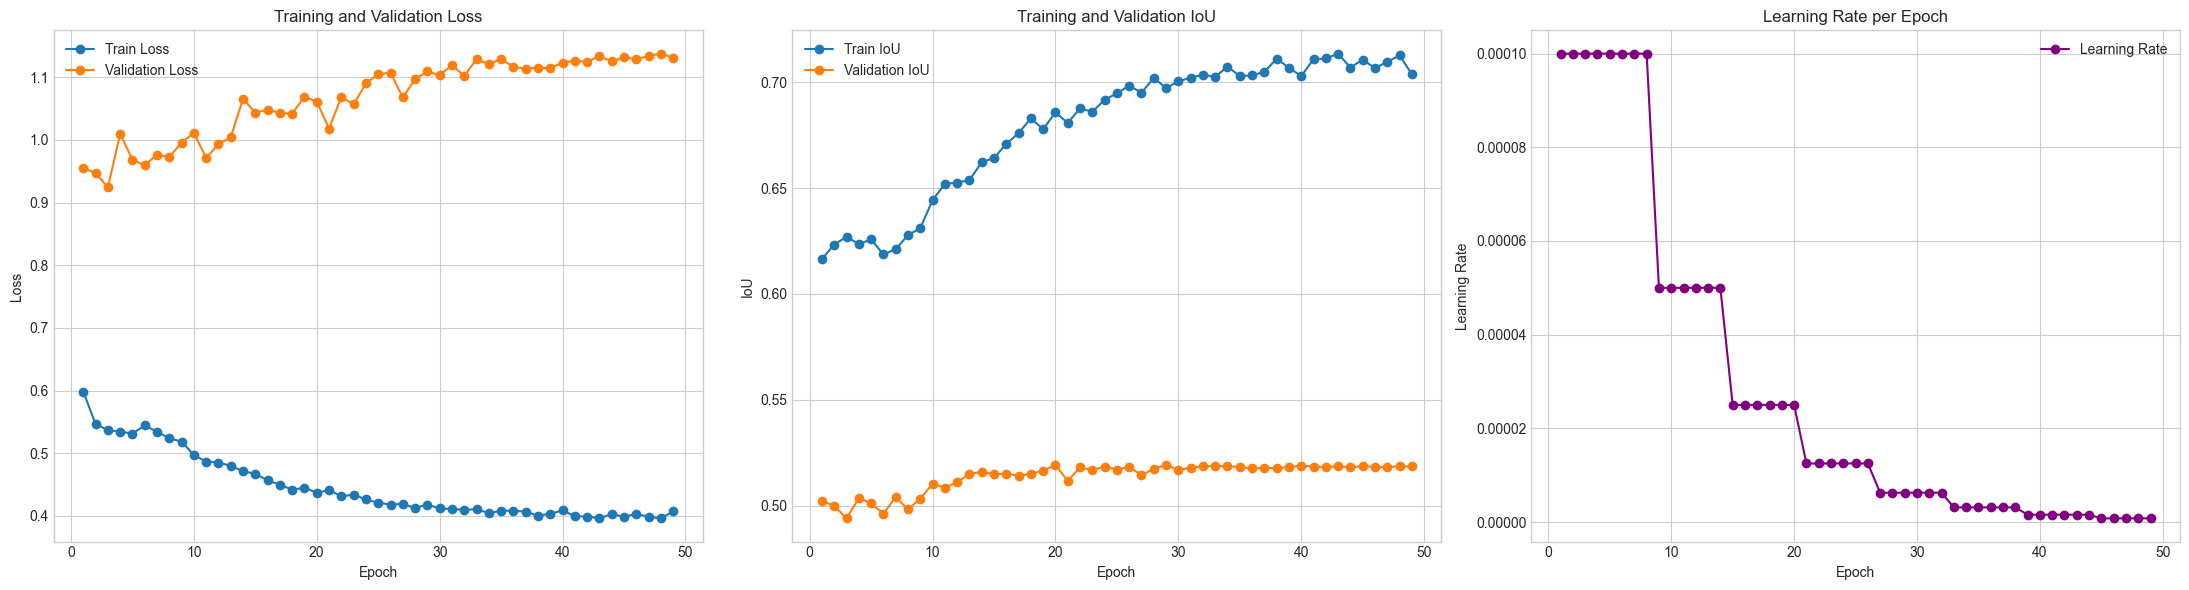


--- Evaluating the best model on the validation set ---


C:\Users\Admin\AppData\Local\Temp\ipykernel_13548\316635104.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(NEW_CHECKPOINT_PATH)['model


--- Evaluation Metrics ---
Precision: 0.6527
Recall:    0.8099
F1-score:  0.7229
IoU:       0.5660


In [ ]:
if __name__ == '__main__':
    # --- Chuẩn bị dữ liệu ---
    train_img_paths = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir)])
    train_mask_paths = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir)])
    val_img_paths = sorted([os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)])
    val_mask_paths = sorted([os.path.join(val_mask_dir, f) for f in os.listdir(val_mask_dir)])

    train_transform = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.RandomRotate90(p=0.5),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    val_transform = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    train_dataset = CrackDetectionDataset(train_img_paths, train_mask_paths, transform=train_transform)
    val_dataset = CrackDetectionDataset(val_img_paths, val_mask_paths, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

    # --- Khởi tạo Model, Optimizer, Loss ---
    print("Initializing iSwinUnet model (paper version)...")
    model = iSwinUnet(num_classes=1, img_size=IMG_SIZE, pretrained=True).to(DEVICE)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7)
    
    pos_weight_value = 22
    criterion = CombinedLoss(pos_weight_value=pos_weight_value).to(DEVICE)
    
    print("="*50)
    print(f"!!! USING BCEWithLogitsLoss with pos_weight={pos_weight_value} !!!")
    print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters.")
    print("="*50)

    INITIAL_WEIGHTS_PATH = 'iswin_unet_paper_IOU.pth'
    # Đường dẫn tệp checkpoint mới cho lần train này (với CombinedLoss)
    NEW_CHECKPOINT_PATH = 'bce_iou_paper.pth'
    
    callbacks_config = {'patience': 20, 'checkpoint_path': NEW_CHECKPOINT_PATH}
    start_epoch, best_val_iou, history = 0, 0.0, None

    if os.path.exists(NEW_CHECKPOINT_PATH):
        print(f"✅ Resuming training from existing checkpoint: {NEW_CHECKPOINT_PATH}")
        checkpoint = torch.load(NEW_CHECKPOINT_PATH, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint.get('optimizer_state_dict'))
        scheduler.load_state_dict(checkpoint.get('scheduler_state_dict'))
        start_epoch = checkpoint.get('epoch', 0) + 1
        best_val_iou = checkpoint.get('best_val_iou', 0.0)
        history = checkpoint.get('history')
        print(f"   Resuming from Epoch {start_epoch}. Best Val IoU so far: {best_val_iou:.4f}")
    elif os.path.exists(INITIAL_WEIGHTS_PATH):
        print(f"✅ Found initial weights at: {INITIAL_WEIGHTS_PATH}")
        print("   Loading model weights for fine-tuning. Optimizer and scheduler are reset.")
        checkpoint = torch.load(INITIAL_WEIGHTS_PATH, map_location=DEVICE)
        # Chỉ tải trọng số mô hình, không tải optimizer, epoch,...
        model.load_state_dict(checkpoint['model_state_dict'])
        print("   Starting new training run from Epoch 0.")
    else:
        print(f"⚠️ No checkpoints found at '{NEW_CHECKPOINT_PATH}' or '{INITIAL_WEIGHTS_PATH}'.")
        print("   Loading default Swin-Tiny weights from Hugging Face for the encoder.")
        model.load_pretrained_weights()
        print("   Starting new training run from scratch (Epoch 0).")


    print(f"\n--- Starting Training ---")
    training_history = train_model(
        model, train_loader, val_loader, optimizer, criterion, scheduler,
        num_epochs=NUM_EPOCHS, callbacks_config=callbacks_config,
        start_epoch=start_epoch, best_val_iou=best_val_iou, history=history
    )
    
    print("\n--- Training complete. ---")

    # --- Vẽ biểu đồ và Đánh giá ---
    if training_history and len(training_history['train_loss']) > 0:
        print("Plotting training history...")
        plot_training_history(training_history)
        
        # Đánh giá trên tập validation với mô hình tốt nhất đã lưu
        print("\n--- Evaluating the best model on the validation set ---")
        model.load_state_dict(torch.load(NEW_CHECKPOINT_PATH)['model_state_dict'])
        evaluate_model(model, val_loader, threshold=0.5)
    else:
        print("No training history available to plot.")

In [8]:
thresholds = np.arange(0.65, 1, 0.005)
all_preds_raw = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, masks in tqdm(val_loader, desc="Collecting predictions"):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        outputs = model(images)
        probs = torch.sigmoid(outputs)

        all_preds_raw.append(probs.view(-1).cpu().numpy())
        all_targets.append(masks.view(-1).cpu().numpy())

all_preds_raw = np.concatenate(all_preds_raw)
all_targets = np.concatenate(all_targets)

metrics = {'threshold': [], 'precision': [], 'recall': [], 'f1': [], 'iou': []}

for t in thresholds:
    preds_bin = (all_preds_raw > t).astype(np.uint8)

    precision = precision_score(all_targets, preds_bin, zero_division=0)
    recall = recall_score(all_targets, preds_bin, zero_division=0)
    f1 = f1_score(all_targets, preds_bin, zero_division=0)
    iou = jaccard_score(all_targets, preds_bin, zero_division=0)

    metrics['threshold'].append(t)
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1'].append(f1)
    metrics['iou'].append(iou)

best_f1_idx = int(np.argmax(metrics['f1']))
best_iou_idx = int(np.argmax(metrics['iou']))

print("\n=== Threshold Tốt Nhất ===")
print(f"[F1]  Best at threshold = {metrics['threshold'][best_f1_idx]:.2f} | F1 = {metrics['f1'][best_f1_idx]:.4f}")
print(f"[IoU] Best at threshold = {metrics['threshold'][best_iou_idx]:.2f} | IoU = {metrics['iou'][best_iou_idx]:.4f}")


=== Threshold Tốt Nhất ===
[F1]  Best at threshold = 0.88 | F1 = 0.7318
[IoU] Best at threshold = 0.88 | IoU = 0.5770


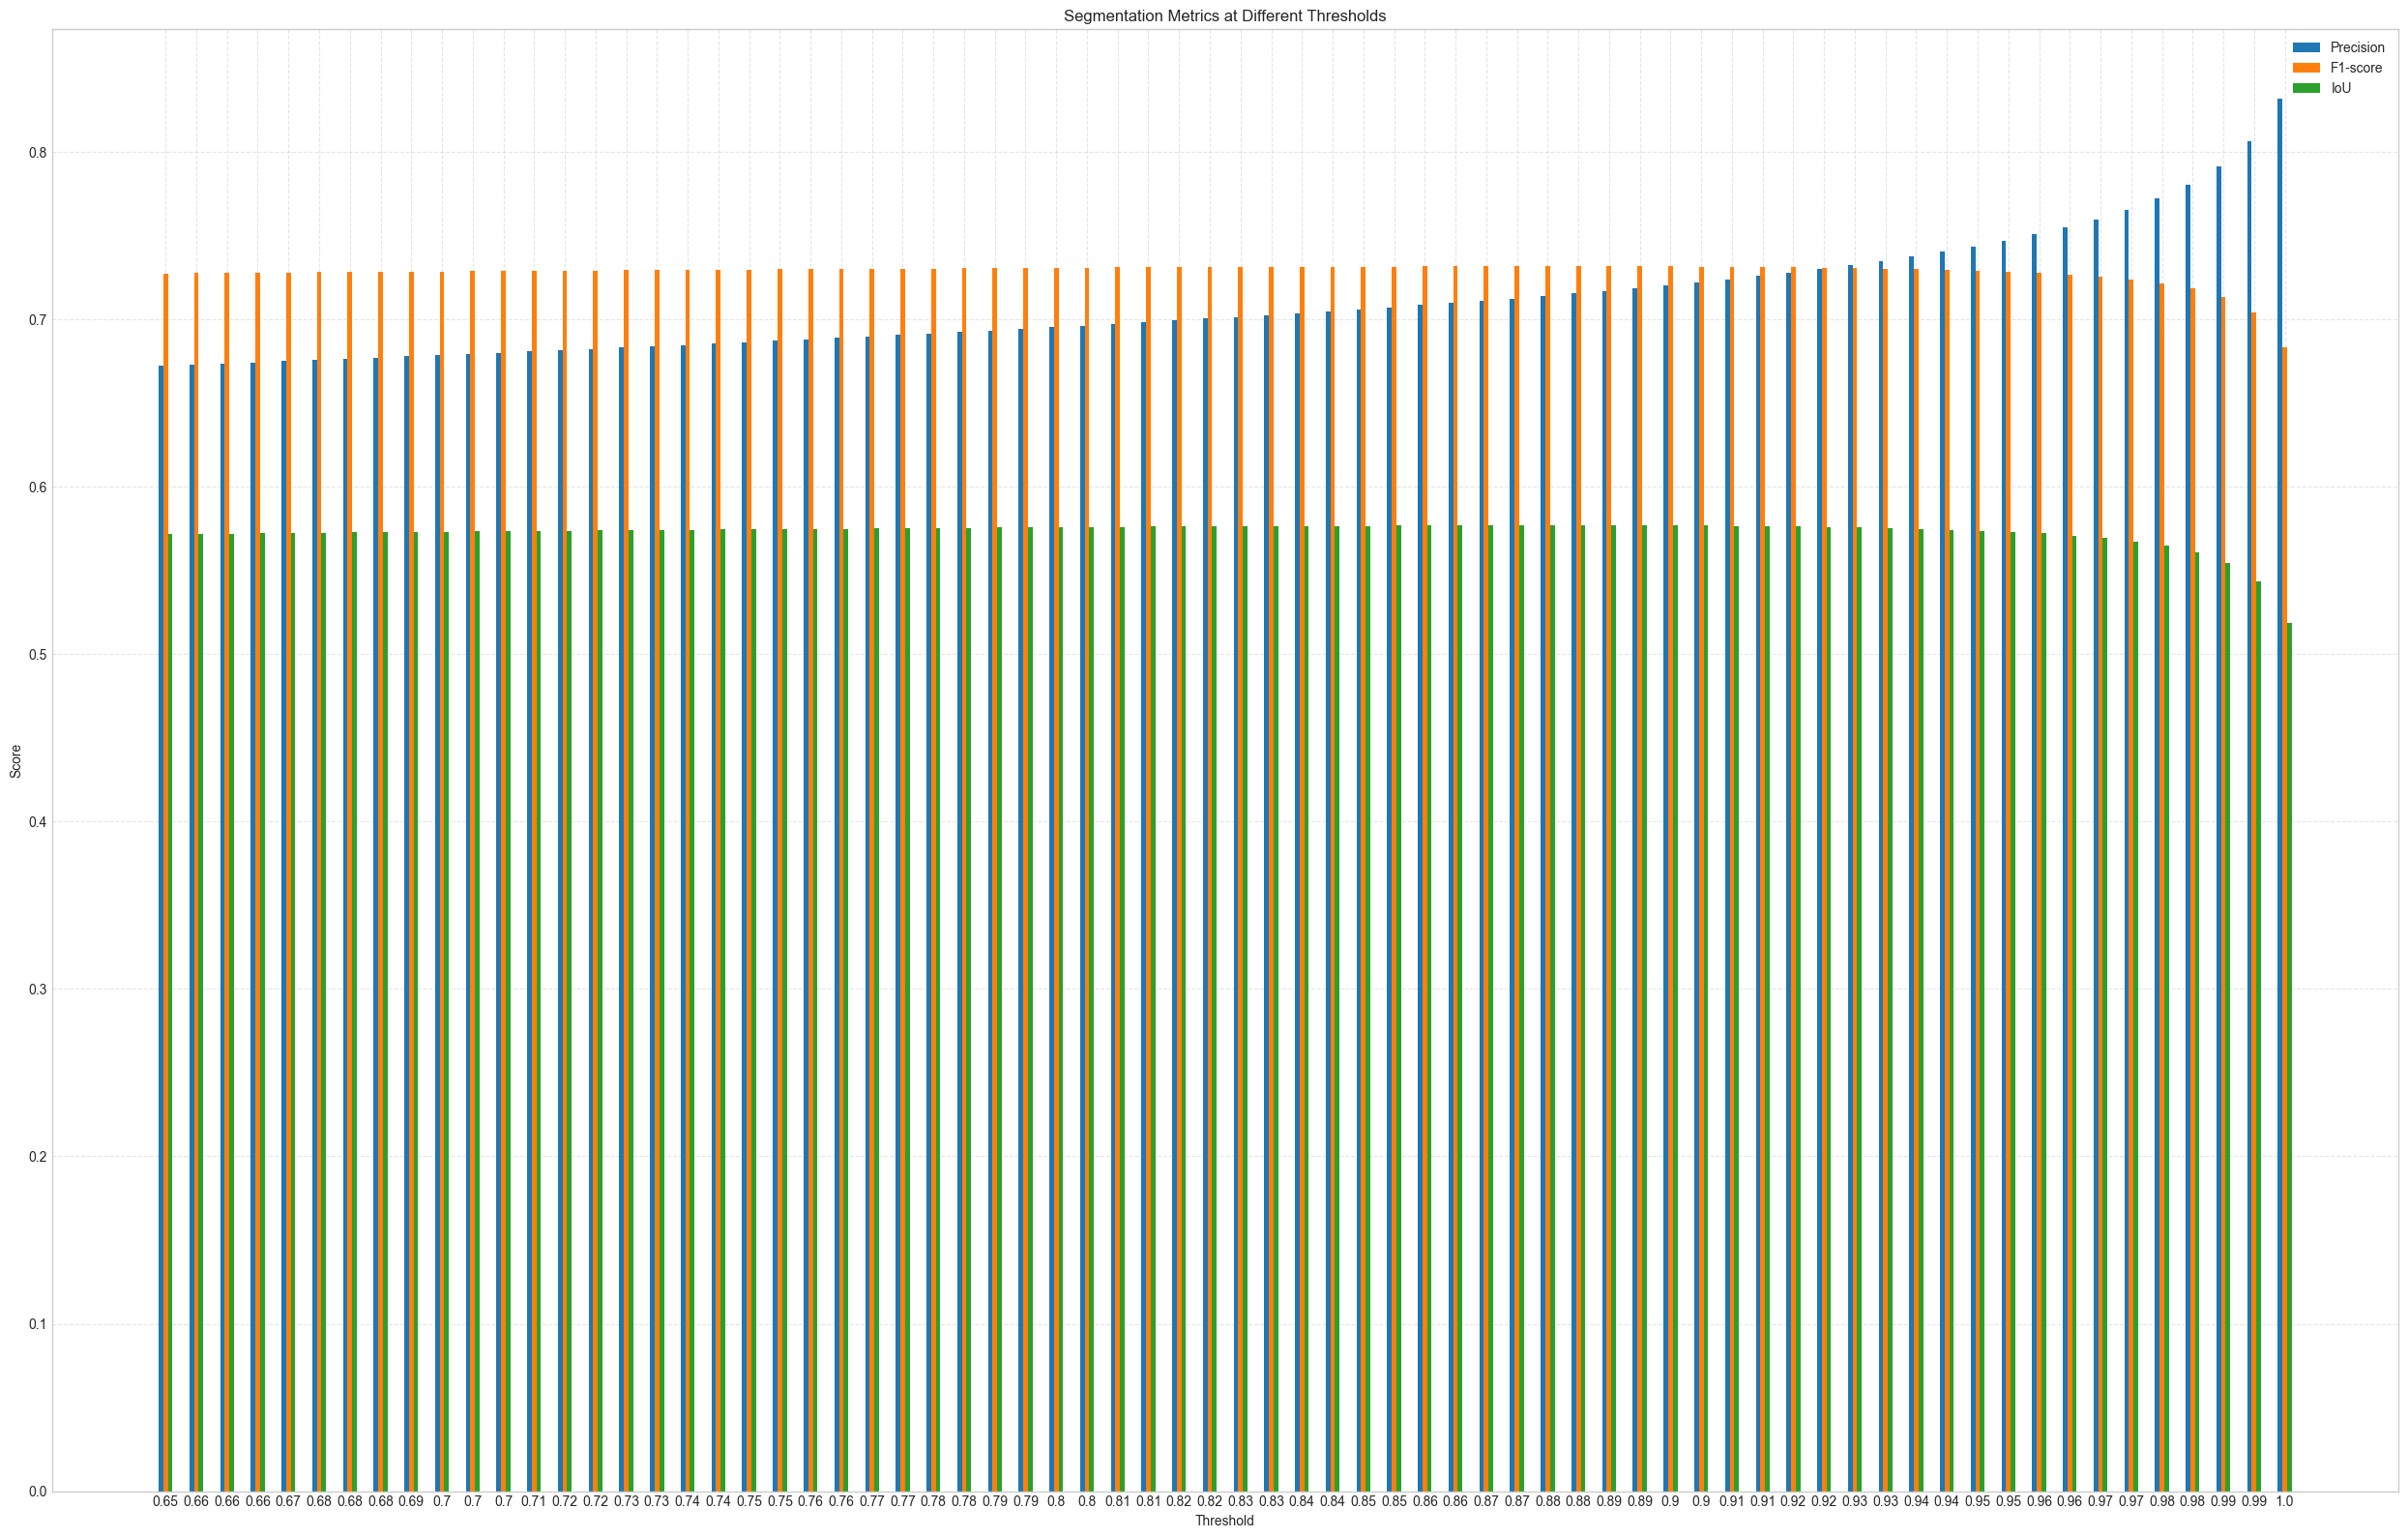

In [9]:
x = [round(t, 2) for t in metrics['threshold']]
x_idx = np.arange(len(x))
width = 0.15

plt.figure(figsize=(25, 16))
plt.bar(x_idx - width, metrics['precision'], width=width, label='Precision')
plt.bar(x_idx, metrics['f1'], width=width, label='F1-score')
plt.bar(x_idx + width, metrics['iou'], width=width, label='IoU')

plt.xticks(x_idx, x)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Segmentation Metrics at Different Thresholds')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()